# Computer Vision Coursework

In [1]:
### Importing necessary libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

## Exploratory Data Analysis

### Basic Stats

In [53]:
### Loading matlab files in Python using Scipy
import scipy.io
mat = scipy.io.loadmat('Brain.mat')

In [54]:
T1, label = mat['T1'], mat['label']

In [55]:
### T1 is the array with the input MRI images, 10 samples each of size 362x434 pixels.
T1.shape

(362, 434, 10)

In [56]:
### range of pixel values in a sample of T1
sample = T1[:,:,0]
print(f"""Max pixel value: {round(sample.min(),0)}, 
Min pixel value: {round(sample.max(),0)},
Average pixel value: {round(sample.mean(),0)}""")

Max pixel value: 959.0, 
Min pixel value: 491434.0,
Average pixel value: 164930.0


- From the above cell, we can see that the obtained input image is not in standard color range `0-255`. Thus, we need to apply the standardisation technique `(x -> (x-xmin)/(xmax-xmin))` that will convert the pixel to the range `[0,1]`. Multiply the obtained pixel values with 255 and take the integer value to get the standard `0-255` representation of the image

In [59]:
sample_std = ((sample - sample.min()) * (1/(sample.max() - sample.min()) * 255)).astype('uint8')
print(f"""Standardized image:
Max pixel value: {round(sample_std.min(),0)}, 
Min pixel value: {round(sample_std.max(),0)},
Average pixel value: {round(sample_std.mean(),0)}""")

Standardized image:
Max pixel value: 0, 
Min pixel value: 255,
Average pixel value: 85.0


### Visualising images

In [110]:
### function to plot single image
def show_image(image,cmap = 'gray',fig_size = 10):
    plt.figure(figsize = (fig_size,fig_size))
    fig  = plt.imshow(image,cmap = cmap)
    plt.show()

### function to visualise label images
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # convert hsv2bgr for visualsiation
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set background label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

### function to plot multiple images as subplot
def plot_multi(images, cmap='gray', fig_size = 20):
    plt.figure(figsize=(fig_size, fig_size))
    length = len(images)
    sq_root = int(length**0.5)
    for i in range(length):
        plt.subplot(sq_root+1,sq_root+1,i+1)
        plt.imshow(images[i],cmap = cmap)
        plt.xlabel(f"index: {i+1}")


#### Plotting original image and Standardised image to check for data loss

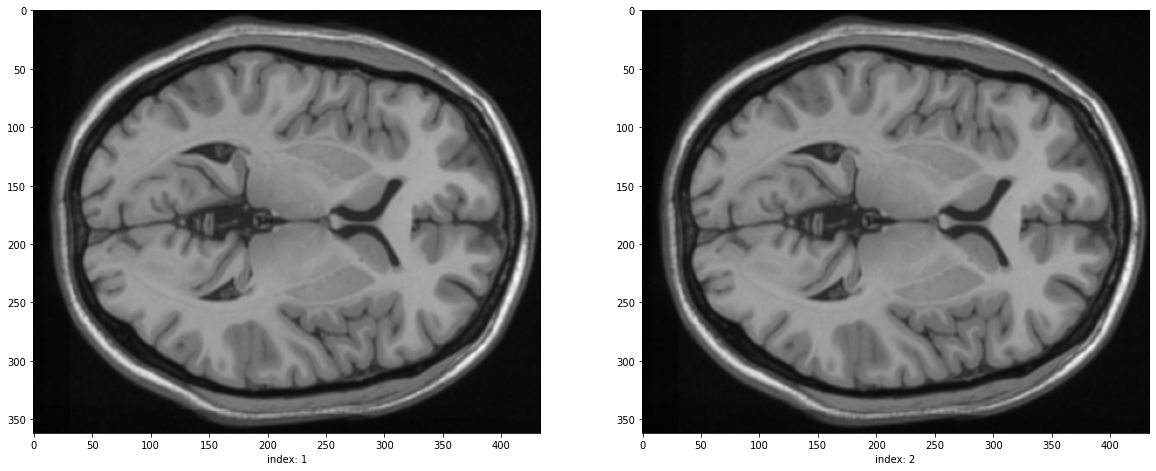

In [111]:
plot_multi([sample, sample_std])

### Storing the images for understanding the data better

In [112]:
### creating a folder to store images
data_folder = 'data'
os.makedirs('data',exist_ok=True)

In [129]:
images = []
labels = []
for i in range(10):
    img = T1[:,:,i]
    
    ### standardising the float values between int of range(0-255)
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    images.append(img)
    lab = label[:,:,i]
    labels.append(lab)
#     lab1 = ((lab - lab.min()) * (1/(lab.max() - lab.min()) * 255)).astype('uint8')
    lab1 = imshow_components(lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image.png'),img)
    cv2.imwrite(os.path.join(data_folder,f'{i}_gt.png'),lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image_gt.png'),lab1)
    
###reference: https://stackoverflow.com/a/49922520/9605907

In [130]:
### listing the created images in the data folder
sorted(os.listdir(data_folder))[0:10]

['.DS_Store',
 '0_gt.png',
 '0_image.png',
 '0_image_gt.png',
 '1_gt.png',
 '1_image.png',
 '1_image_gt.png',
 '2_gt.png',
 '2_image.png',
 '2_image_gt.png']

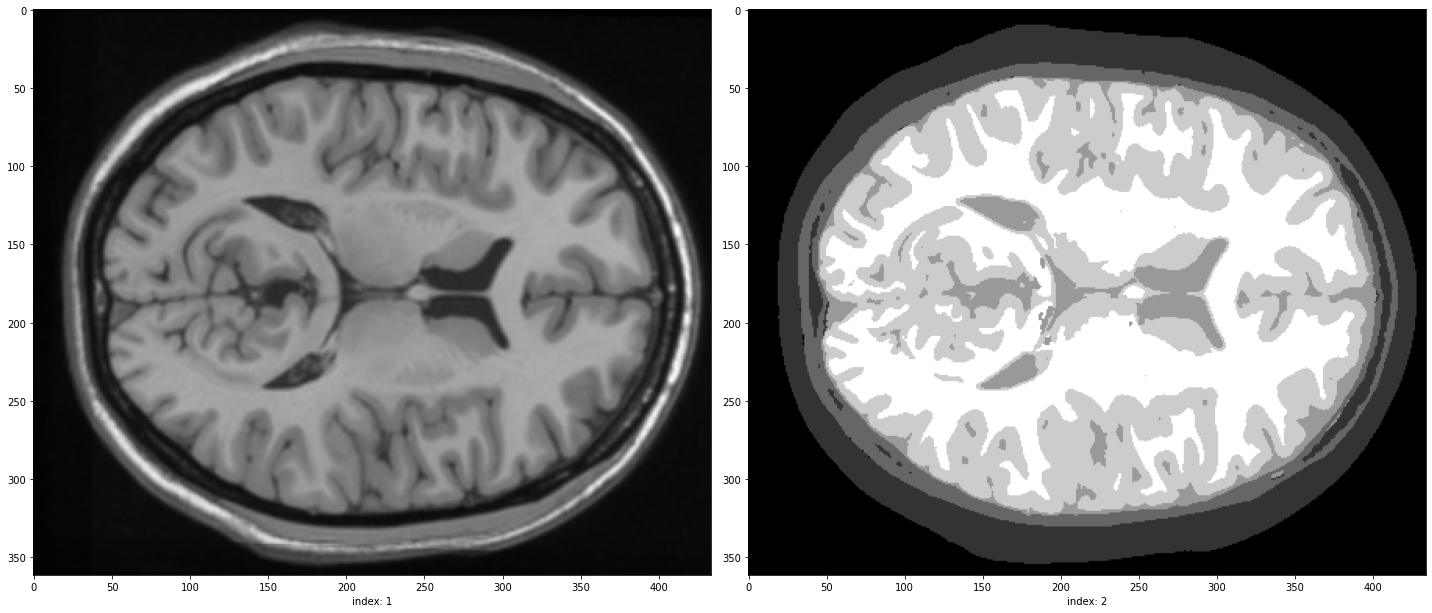

In [131]:
### Visualising a sample input image and it's expected groundtruth
plot_multi([images[9],labels[9]],cmap = 'gray')

### Segementation classes

- For a given MRI image, we need to segment them into 6 categories namely: air, skin, skull, csf, gray matter and white matter

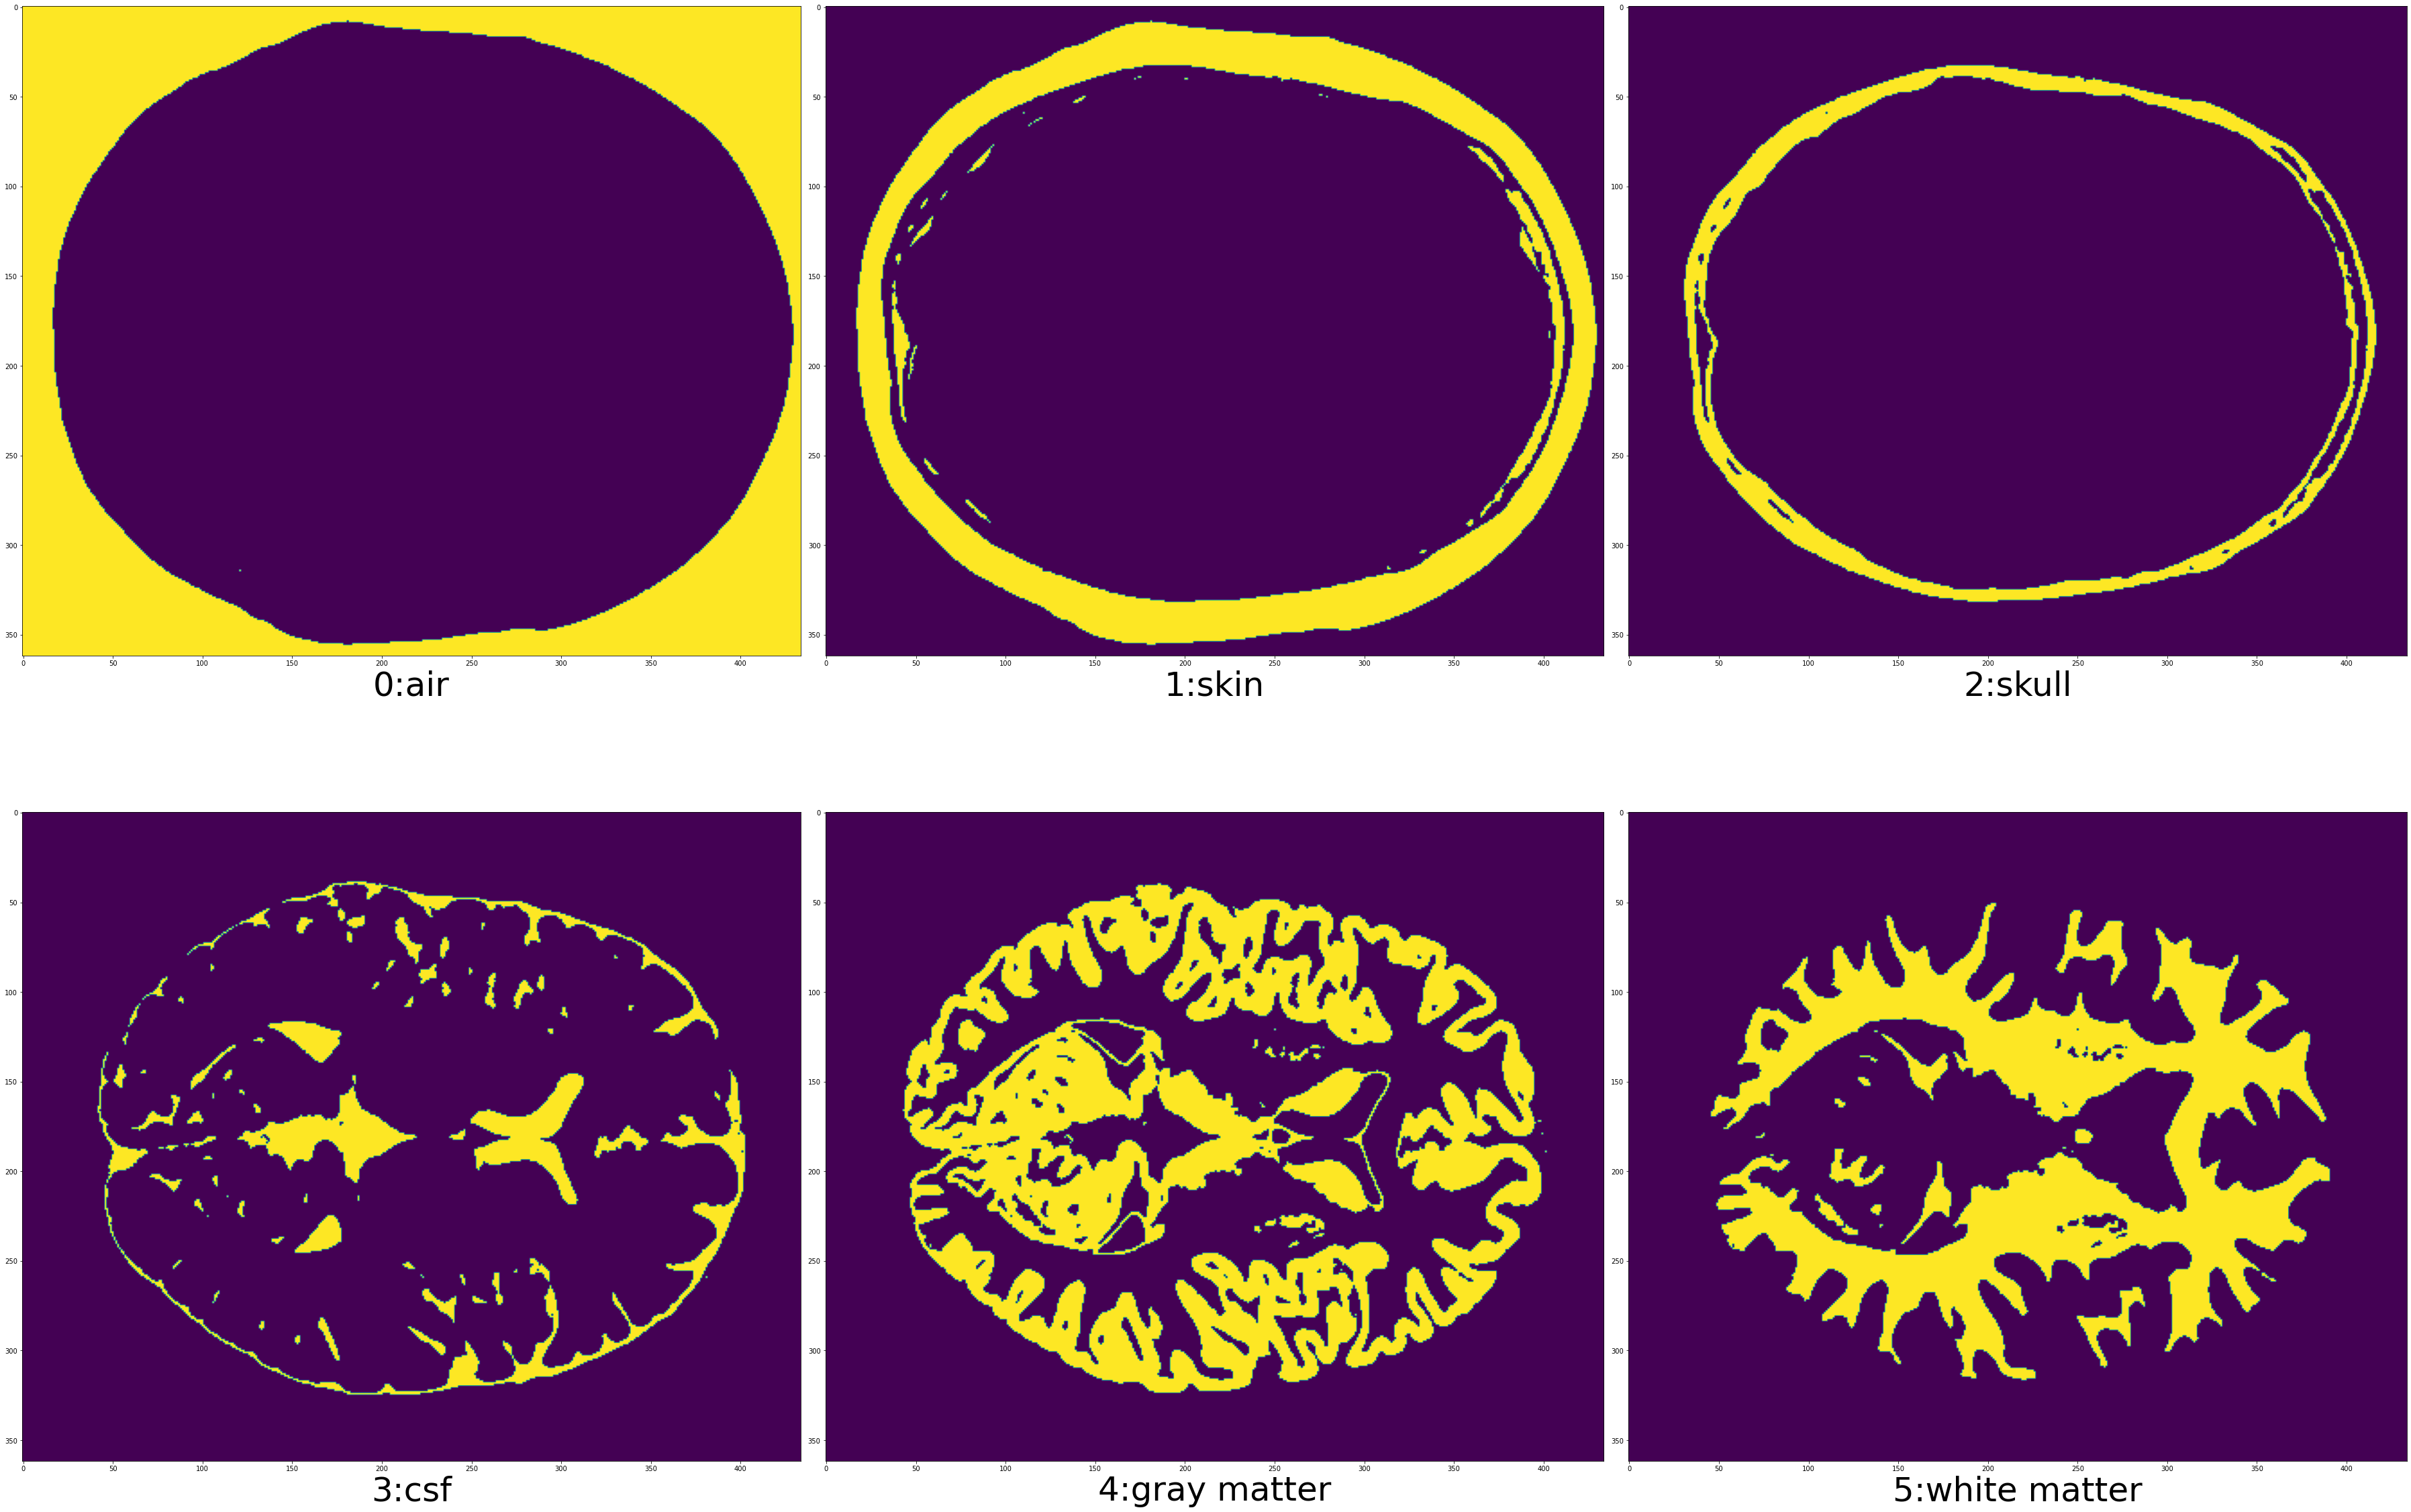

In [132]:
input_image = images[5]
label_image = labels[5]
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

## MRI Segementation - Approach 1 : Thresholding

- From the data, we can see that the pixels values are different for different segments and we can arrive at a basic segmentaion model by applying thresholding at multiple levels. 

### Plotting Histogram of a sample image 

(0.0, 256.0)

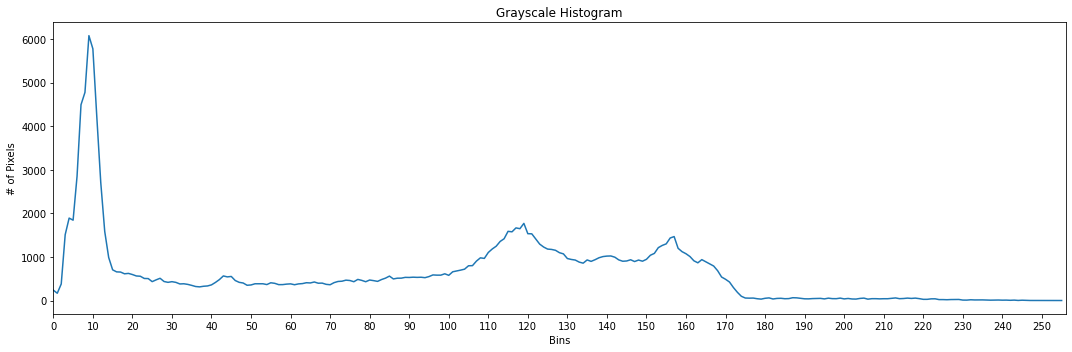

In [133]:
hist = cv2.calcHist([input_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])